# Extract Overshoot from Profiles

In [1]:
%matplotlib inline

import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal
import matplotlib.ticker as mticker
import math
import csv

%config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 12.
plt.rcParams['lines.markeredgewidth'] = 0.7

In [2]:
main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'
fname = os.path.join(main_path,'[!m]*')
fileL = glob.glob(fname) #list of files
[fileL.remove(file) for file in fileL if 'Plume' in file];
[fileL.remove(file) for file in fileL if '6e7' in file];
path_list = sorted (fileL, key = lambda x: (len (x), x))
fileL = [file.replace(main_path,'') for file in fileL]
ra_path = sorted (fileL, key = lambda x: (len (x), x))

lenRa = len(ra_path)

In [3]:
data = [[] for i in range(lenRa)] #empty nested list

for i in range(lenRa-1):
    if ra_path[i]=='6e7':
        continue
#     if ra_path[i]=='3e8':
#         fname = os.path.join(path_list[i]+'\\512\\','[!m]*.txt')
#     else:
#         fname = os.path.join(path_list[i]+'\\256\\','[!m]*.txt')
    fname = os.path.join(path_list[i]+'\\256\\','[!m]*.txt')
    fileL = glob.glob(fname) #list of files
    temp = []
    for file in fileL:
        a = fileL.index(file)
        b = pd.read_csv(file,header=None)
        b.rename(columns={0:a}, inplace=True)
        temp.append(b)
#     if ra_path[i]=='3e8':
#         toDF = np.reshape(temp,(3,513),order='A')
#     else:
#         toDF = np.reshape(temp,(3,257),order='A') 
    toDF = np.reshape(temp,(3,257),order='A') 
    DF = pd.DataFrame(toDF.T)
    DF.rename(columns={0:'Radius',2:'Temperature',1:'Velocity'},inplace=True)
    DF['Ra']=float(ra_path[i])
    data[i] = DF

,Ra,Depth,Overshoot,Interior,Difference
0,1.000000e+04,0.684615,0.511778,0.500006,0.011773
1,1.000000e+05,0.869231,0.518730,0.499990,0.018740
2,1.000000e+06,0.937999,0.521842,0.499950,0.021892
3,3.000000e+06,0.953125,0.541313,0.499973,0.041339
4,1.000000e+07,0.967188,0.541997,0.499960,0.042037
5,3.000000e+07,0.975000,0.539941,0.502318,0.037623
6,1.000000e+08,0.982500,0.535148,0.498985,0.036163
7,3.000000e+08,0.983594,0.519676,0.499984,0.019692
8,6.000000e+08,0.986875,0.524438,0.503425,0.021013
9,1.000000e+09,0.987969,0.522263,0.500732,0.021531


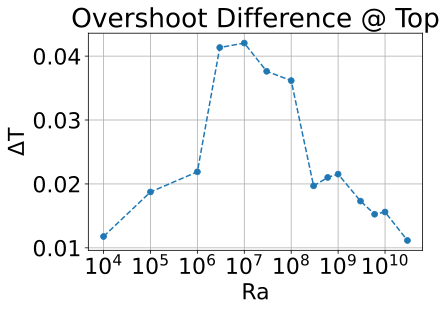

In [22]:
to = []
ti = []
ra = []
zz = []
for i in range(lenRa-1):
    max_len = len(data[i]['Temperature'])
    mid_len = int(len(data[i]['Temperature'])/2)
    to.append(data[i]['Temperature'].truncate(before=mid_len, after=max_len).max())
    ti.append(data[i]['Temperature'][mid_len])
    ra.append(data[i]['Ra'][0])
    idx = np.where(data[i]['Temperature']==data[i]['Temperature'].truncate(before=mid_len, after=max_len).max())[0][0]
    zz.append(data[i]['Radius'][idx])
to = np.array(to)
ti = np.array(ti)
ra = np.array(ra)
zz = np.array(zz)

result = pd.DataFrame({'Ra': ra, 'Depth' : zz,'Overshoot': to, 'Interior': ti, 'Difference':to-ti})
result = result.sort_values(by=['Ra'])
result = result.reset_index(drop=True)

plt.rcParams['figure.figsize'] = [6,4]
plt.plot(result['Ra'],result['Difference'],'.',linestyle='--')
plt.xscale('log');
# plt.axvline(3e6);
plt.title('Overshoot Difference @ Top')
plt.xlabel('Ra')
plt.ylabel('ΔT');
plt.grid()
plt.xticks(np.logspace(4,10,num=7));

image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_top.png',pad_inches=0.1,bbox_inches='tight');
save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
result

,Ra,Overshoot,Interior,Difference
0,1.000000e+04,0.488232,0.500006,-0.011774
1,1.000000e+05,0.481250,0.499990,-0.018740
2,1.000000e+06,0.478128,0.499950,-0.021822
3,3.000000e+06,0.458612,0.499973,-0.041361
4,1.000000e+07,0.457930,0.499960,-0.042030
5,3.000000e+07,0.463334,0.502318,-0.038984
6,1.000000e+08,0.461177,0.498985,-0.037809
7,3.000000e+08,0.478111,0.499984,-0.021873
8,6.000000e+08,0.480889,0.503425,-0.022536
9,1.000000e+09,0.479485,0.500732,-0.021247


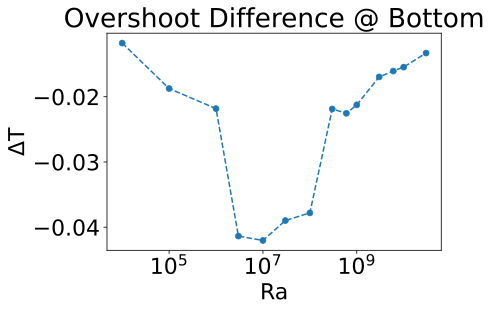

In [5]:
to = []
ti = []
ra = []
for i in range(lenRa-1):
    max_len = len(data[i]['Temperature'])
    mid_len = int(len(data[i]['Temperature'])/2)
    to.append(data[i]['Temperature'].truncate(before=0, after=mid_len).min())
    ti.append(data[i]['Temperature'][mid_len])
    ra.append(data[i]['Ra'][0])
to = np.array(to)
ti = np.array(ti)
ra = np.array(ra)

result2 = pd.DataFrame({'Ra': ra, 'Overshoot': to, 'Interior': ti, 'Difference':to-ti})
result2 = result2.sort_values(by=['Ra'])
result2 = result2.reset_index(drop=True)

plt.rcParams['figure.figsize'] = [6,4]
plt.plot(result2['Ra'],result2['Difference'],'.',linestyle='--')
plt.xscale('log');
# plt.axvline(3e6);
plt.title('Overshoot Difference @ Bottom')
plt.xlabel('Ra')
plt.ylabel('ΔT');
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_bot.png',pad_inches=0.1,bbox_inches='tight');

result2

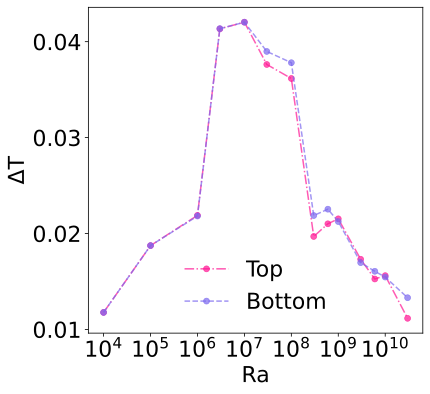

In [6]:
plt.rcParams['figure.figsize'] = [6,6]
plt.plot(result['Ra'],abs(result['Difference']),'.',linestyle='-.',alpha=0.7,label='Top', color='deeppink')
plt.plot(result2['Ra'],abs(result2['Difference']),'.',linestyle='--',alpha=0.7,label='Bottom', color='mediumslateblue')
plt.xscale('log');
# plt.title('Overshoot Difference Both')
plt.xlabel('Ra')
plt.ylabel('ΔT');
plt.xticks(np.logspace(4,10,num=7));
plt.yticks(np.linspace(0.01,0.04,num=4));
plt.legend(frameon=False,loc='lower center');
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_both.png',pad_inches=0.1,bbox_inches='tight');

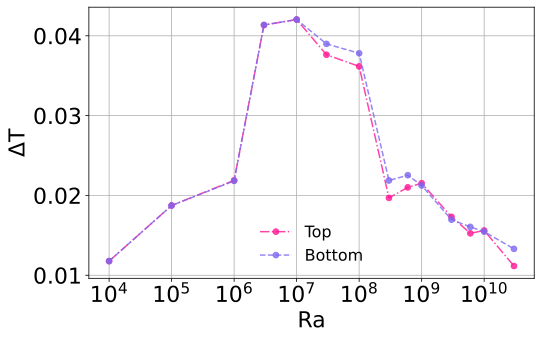

In [7]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(result['Ra'],abs(result['Difference']),'.',linestyle='-.',alpha=0.8,label='Top', color='deeppink')
plt.plot(result2['Ra'],abs(result2['Difference']),'.',linestyle='--',alpha=0.8,label='Bottom', color='mediumslateblue')
plt.xscale('log');
# plt.title('Overshoot Difference Both')
plt.xlabel('Ra')
plt.ylabel('ΔT');
plt.xticks(np.logspace(4,10,num=7));
plt.legend(frameon=False,prop={'size': 16},loc='lower center');
image_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Images\\'
plt.savefig(image_path + 'overshoot_both_long.png',pad_inches=0.1,bbox_inches='tight');
plt.grid();

In [14]:
average_top_bot = (abs(result['Difference'])+abs(result2['Difference']))/2
result = result.drop(['Interior','Overshoot','Difference'],axis=1)
result.insert(2, 'Difference', average_top_bot, True)
result

,Ra,Depth,Difference
0,1.000000e+04,0.684615,0.011773
1,1.000000e+05,0.869231,0.018740
2,1.000000e+06,0.937999,0.021857
3,3.000000e+06,0.953125,0.041350
4,1.000000e+07,0.967188,0.042034
5,3.000000e+07,0.975000,0.038303
6,1.000000e+08,0.982500,0.036986
7,3.000000e+08,0.983594,0.020782
8,6.000000e+08,0.986875,0.021774
9,1.000000e+09,0.987969,0.021389


In [17]:
result.to_csv(save_path+'overshoot_data.csv', index=False)

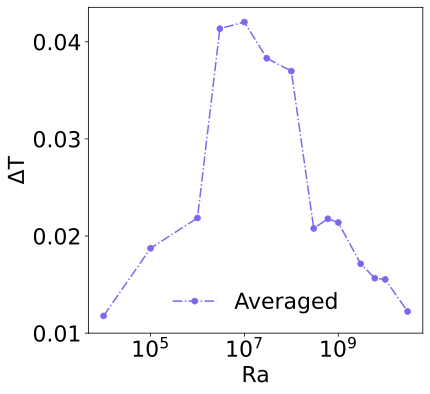

In [16]:
plt.rcParams['figure.figsize'] = [6,6]
# average_top_bot = (abs(result['Difference'])+abs(result2['Difference']))/2
fig = plt.figure(facecolor='white')
plt.plot(result['Ra'],result['Difference'],'.',linestyle='-.',label='Averaged',color='mediumslateblue')
plt.xscale('log');
plt.xlabel('Ra'); plt.ylabel('ΔT');
# plt.xticks(np.logspace(4,10,num=7));
plt.yticks(np.linspace(0.01,0.04,num=4));
plt.legend(frameon=False,loc='lower center');
plt.savefig(image_path + 'overshoot_averaged.png',pad_inches=0.1,bbox_inches='tight');
plt.savefig(image_path + 'SVG\\overshoot_averaged.svg',pad_inches=0.1,bbox_inches='tight');

In [18]:
save_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions_Data\\'
Data=pd.read_csv(save_path+'data_short.csv')
Data.drop(Data.tail(1).index,inplace = True)
Data

,Ra,NuT,NuB,VRMS,Surface
0,1.000000e+04,4.656117,4.656052,34.289954,31.914000
1,1.000000e+05,11.254625,11.254650,168.172663,165.990000
2,1.000000e+06,23.502768,23.502513,703.962729,710.800000
3,3.000000e+06,31.097748,31.097102,1728.708096,1861.388378
4,1.000000e+07,45.598467,45.599319,3732.439045,4010.006207
5,3.000000e+07,62.639594,62.539980,6915.399625,7357.209091
6,1.000000e+08,92.484450,92.242470,14745.362244,15468.777512
7,3.000000e+08,113.137404,113.297158,17386.847212,16552.034302
8,6.000000e+08,145.749153,145.132127,30136.178700,28953.937824
9,1.000000e+09,174.398691,172.451075,39692.511465,37128.398551


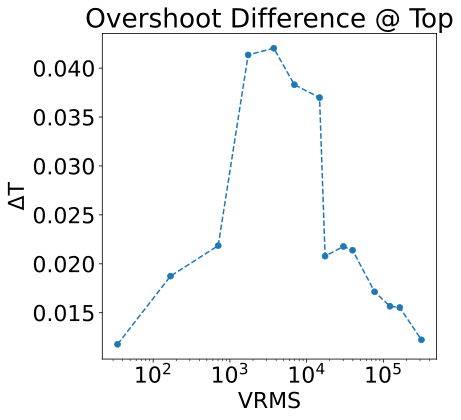

In [19]:
plt.plot(Data['VRMS'],result['Difference'],'.',linestyle='--')
plt.xscale('log');
# plt.axvline(3e6);
plt.title('Overshoot Difference @ Top')
plt.xlabel('VRMS')
plt.ylabel('ΔT');

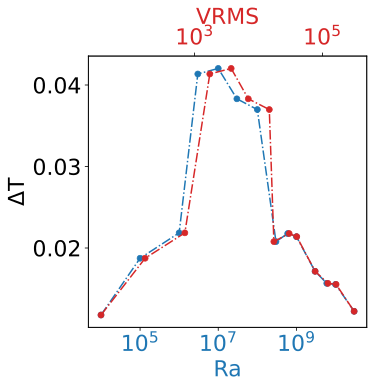

In [20]:
fig, ax1 = plt.subplots(figsize=(5,5))
plt.xscale('log'); 
plt.xlabel('Ra')
plt.ylabel('ΔT')
# plt.xticks(np.logspace(4,10,num=7));
color = 'tab:blue'
ax1.set_xlabel('Ra', color=color);
ax1.tick_params(axis='x', labelcolor=color);
ax2 = ax1.twiny()  
ax1.plot(result['Ra'],result['Difference'],'.',linestyle='-.')
plt.xscale('log'); 
color = 'tab:red'
ax2.plot(Data['VRMS'],result['Difference'],'.',linestyle='-.',color=color)
plt.xscale('log');
# plt.xticks(np.logspace(4,10,num=7));
ax2.set_xlabel('VRMS', color=color);
ax2.tick_params(axis='x', labelcolor=color);

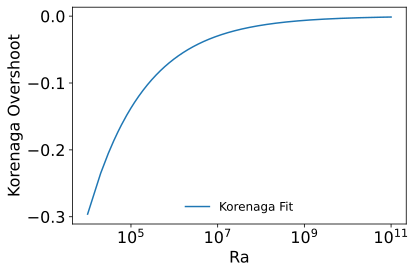

In [38]:
plt.rcParams['font.size'] = 16
xx = np.arange(1e4,1e11,1e4)
hola = -10.39*xx**(-1/3) + 4.01*xx**(1/3-2/3)
sigma = result['Overshoot'] + 1 - result2['Overshoot'] - 1
plt.plot(xx,hola, label = 'Korenaga Fit')
# plt.plot(result['Ra'],sigma,'.', label = 'My Data')
plt.xscale('log');
# plt.yscale('log');
plt.xlabel('Ra');
plt.ylabel('Korenaga Overshoot');
plt.legend(frameon=False,prop={'size': 12},loc='lower center');

In [36]:
hola

array([-0.29613337, -0.23504121, -0.20532741, ..., -0.00137453,
       -0.00137453, -0.00137453])